<div align="center"><span style="font-family:arialblack;font-size:26px;color:red"> Prédire les transactions frauduleuses </span></div><br><br><hr>

## 1. Importation des bibliothèques nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

## 2. Récupérer les données nécessaires 

In [ ]:
# prendre seulement des colonnes importantes 

input_file = r"C:\Users\vakch\Desktop\Formation Data Analyst\Projet\transactions_rebalanced_pays.csv"
output_file = r"C:\Users\vakch\Desktop\Formation Data Analyst\Projet\transac_ml.csv"

chunksize = 300_000
first_chunk = True

# Colonnes à conserver
COLUMNS_TO_KEEP = [
    "transaction_id",      
    "timestamp",          
    "amount",
    "country",
    "card_present",            
    "distance_from_home",
    "merchant_category",
    "weekend_transaction",
    "is_fraud"
]

# Traitement par chunks

for chunk in pd.read_csv(input_file, chunksize=chunksize):

    # Garder uniquement les colonnes utiles
    chunk_light = chunk[COLUMNS_TO_KEEP]

    # Écriture progressive
    if first_chunk:
        chunk_light.to_csv(output_file, index=False, mode="w")
        first_chunk = False
    else:
        chunk_light.to_csv(output_file, index=False, mode="a", header=False)

    print(f"✅ Chunk traité : {len(chunk_light)} lignes")

print("✅ Fichier allégé prêt pour le Machine Learning")

In [2]:
# transformer le fichier excel en parquet car ça prendra moins de temps 

output_file = r"C:\Users\vakch\Desktop\Formation Data Analyst\Projet\transac_ml.csv"
df = pd.read_csv(output_file)
df.to_parquet("transactions_ml_light.parquet", engine="pyarrow")
df.sample(5)

,transaction_id,timestamp,amount,country,card_present,distance_from_home,merchant_category,weekend_transaction,is_fraud
1727394,TX_f1487ffb,2024-10-07 18:49:14.923446+00:00,77329.43,Nigeria,False,0,Healthcare,False,False
6078260,TX_84732670,2024-10-29 11:46:33.645372+00:00,284.10,Germany,False,0,Gas,False,False
335946,TX_3b01444f,2024-10-01 18:21:13.276011+00:00,168568.59,Nigeria,False,0,Entertainment,False,False
348400,TX_b285e680,2024-10-01 19:19:51.095990+00:00,2032.62,USA,False,0,Travel,False,False
4747660,TX_fd156922,2024-10-22 17:34:33.517183+00:00,7870.80,Mexico,False,0,Retail,False,False


In [3]:
# vérifier s'il y a des valeurs nuls 
df.isnull().sum()
df[df.isnull().any(axis=1)]

,transaction_id,timestamp,amount,country,card_present,distance_from_home,merchant_category,weekend_transaction,is_fraud


## 3. Nettoyage des données et création des colonnes & dummies

In [4]:
# diviser la colonne timestamp en date and hour and supprimer la colonne timestamp 

# Conversion en datetime en laissant pandas inférer le format
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')

# Créer la colonne date au format YYYY-MM-DD
df["date"] = df["timestamp"].dt.day
# Créer la colonne heure au format HH:MM
df["heure"] = df["timestamp"].dt.hour

# Supprimer la colonne timestamp
df = df.drop(columns=['timestamp'])

# Vérifier le résultat
df.sample(5)

,transaction_id,amount,country,card_present,distance_from_home,merchant_category,weekend_transaction,is_fraud,date,heure
4782443,TX_1c4d4a3f,18878.23,Japan,False,0,Gas,False,False,22.0,20.0
2236304,TX_c2373226,43.97,USA,False,0,Entertainment,False,False,10.0,7.0
5786775,TX_aa92b708,710.92,Singapore,False,0,Grocery,True,False,27.0,22.0
963403,TX_bece0993,142881.64,Mexico,False,1,Travel,True,True,6.0,5.0
3352182,TX_ba99b006,242.08,UK,False,1,Travel,False,False,15.0,16.0


In [5]:
# vérifier s'il y a des valeurs nuls 
df.isnull().sum()
df[df.isnull().any(axis=1)]
# supprimer les lignes nuls 
df = df.dropna()
df.isnull().sum()

transaction_id         0
amount                 0
country                0
card_present           0
distance_from_home     0
merchant_category      0
weekend_transaction    0
is_fraud               0
date                   0
heure                  0
dtype: int64

In [6]:
exchange_rate_map = {
    "UK": 1.14,
    "Brazil": 0.157,
    "Japan": 0.0055,
    "Australia": 0.664,
    "Nigeria": 0.0011,
    "Germany": 1.0,
    "Mexico": 0.047,
    "Russia": 0.01,
    "France": 1.0,
    "Canada": 0.616,
    "Singapore": 0.771,
    "USA": 0.85
}

# Appliquer le taux de change à la nouvelle colonne amount_eur
df['amount_eur'] = df['amount'] * df['country'].map(exchange_rate_map)
df['amount_eur'] = df['amount_eur'].round(2)

# supprimer la colonne amount 
df = df.drop(columns=['amount'])


In [7]:
# créer une colonne periode de la journée 
def period_of_day(hour):
    if 0 <= hour <= 5:
        return "night"
    elif 6 <= hour <= 11:
        return "morning"
    elif 12 <= hour <= 17:
        return "afternoon"
    else:
        return "evening"

df["period_of_day"] = df["heure"].apply(period_of_day)

In [8]:
df = pd.get_dummies(df, columns=["period_of_day"], drop_first=True)
df.sample(5)

,transaction_id,country,card_present,distance_from_home,merchant_category,weekend_transaction,is_fraud,date,heure,amount_eur,period_of_day_evening,period_of_day_morning,period_of_day_night
5501513,TX_667daeb9,Nigeria,False,0,Grocery,True,False,26.0,14.0,133.42,False,False,False
371988,TX_52a9b014,Singapore,False,0,Healthcare,False,False,1.0,22.0,619.12,True,False,False
6116455,TX_e6525d58,Nigeria,False,0,Restaurant,False,False,29.0,15.0,97.41,False,False,False
4095224,TX_455ac5fe,Mexico,False,0,Healthcare,True,False,19.0,12.0,178.79,False,False,False
6182074,TX_213c6c93,USA,False,0,Healthcare,False,False,29.0,22.0,459.99,True,False,False


In [9]:
df = pd.get_dummies(df, columns=["country"], drop_first=True)
df.sample(5)

,transaction_id,card_present,distance_from_home,merchant_category,weekend_transaction,is_fraud,date,heure,amount_eur,period_of_day_evening,...,country_Canada,country_France,country_Germany,country_Japan,country_Mexico,country_Nigeria,country_Russia,country_Singapore,country_UK,country_USA
6357192,TX_0ff06601,False,0,Education,False,False,30.0,19.0,657.13,True,...,False,False,False,False,False,False,False,True,False,False
4003584,TX_eb32c8e3,False,0,Entertainment,False,False,18.0,22.0,166.11,True,...,False,False,False,False,False,False,False,False,False,False
2636767,TX_9d0adddc,False,0,Education,True,False,12.0,6.0,410.87,False,...,False,False,False,False,False,False,False,False,False,True
2654050,TX_105106fe,False,0,Healthcare,True,False,12.0,8.0,157.29,False,...,False,False,False,False,False,True,False,False,False,False
802756,TX_17e35ea8,False,1,Education,False,False,3.0,16.0,60.60,False,...,False,False,False,False,False,False,True,False,False,False


In [10]:
df = pd.get_dummies(df, columns=["merchant_category"], drop_first=True)
df.sample(5)

,transaction_id,card_present,distance_from_home,weekend_transaction,is_fraud,date,heure,amount_eur,period_of_day_evening,period_of_day_morning,...,country_Singapore,country_UK,country_USA,merchant_category_Entertainment,merchant_category_Gas,merchant_category_Grocery,merchant_category_Healthcare,merchant_category_Restaurant,merchant_category_Retail,merchant_category_Travel
5303279,TX_42bff5c1,False,0,False,False,25.0,13.0,440.99,False,False,...,False,False,True,False,False,True,False,False,False,False
291484,TX_c78a9d36,False,0,False,False,1.0,13.0,394.88,False,False,...,False,True,False,False,False,False,True,False,False,False
5258156,TX_2dd0c73f,False,0,False,False,25.0,9.0,107.37,False,True,...,False,False,False,False,False,False,False,False,False,False
5480295,TX_aed6d392,False,0,True,False,26.0,12.0,138.35,False,False,...,False,False,False,False,False,False,False,False,False,True
5245401,TX_72a7d1bf,False,0,False,False,25.0,8.0,243.86,False,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6395838 entries, 0 to 6395847
Data columns (total 29 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   transaction_id                   object 
 1   card_present                     bool   
 2   distance_from_home               int64  
 3   weekend_transaction              bool   
 4   is_fraud                         bool   
 5   date                             float64
 6   heure                            float64
 7   amount_eur                       float64
 8   period_of_day_evening            bool   
 9   period_of_day_morning            bool   
 10  period_of_day_night              bool   
 11  country_Brazil                   bool   
 12  country_Canada                   bool   
 13  country_France                   bool   
 14  country_Germany                  bool   
 15  country_Japan                    bool   
 16  country_Mexico                   bool   
 17  country_Niger

In [12]:
# transformer les données booléannes en int 
bool_cols = df.select_dtypes('bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6395838 entries, 0 to 6395847
Data columns (total 29 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   transaction_id                   object 
 1   card_present                     int32  
 2   distance_from_home               int64  
 3   weekend_transaction              int32  
 4   is_fraud                         int32  
 5   date                             float64
 6   heure                            float64
 7   amount_eur                       float64
 8   period_of_day_evening            int32  
 9   period_of_day_morning            int32  
 10  period_of_day_night              int32  
 11  country_Brazil                   int32  
 12  country_Canada                   int32  
 13  country_France                   int32  
 14  country_Germany                  int32  
 15  country_Japan                    int32  
 16  country_Mexico                   int32  
 17  country_Niger

## 4.Des données descriptives pour la colonne amount 

In [14]:
#affichage des statistiques descriptives 
df["amount_eur"].describe().round()

count    6395838.0
mean         468.0
std          565.0
min            0.0
25%          186.0
50%          330.0
75%          522.0
max        15622.0
Name: amount_eur, dtype: float64

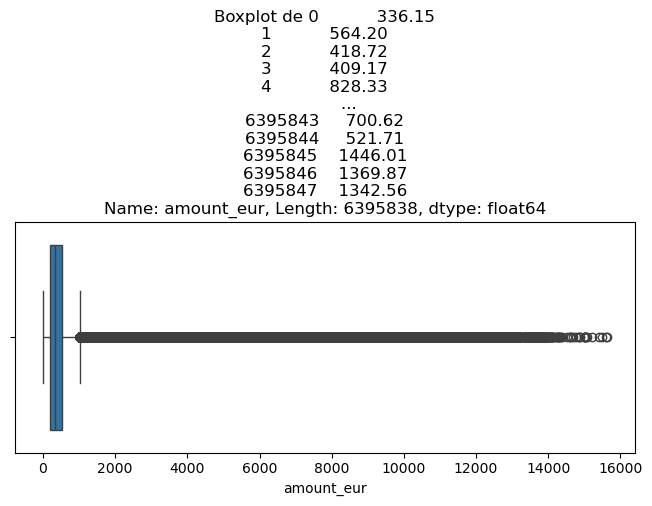

In [18]:
plt.figure(figsize=(8,3))
#plt.subplot(1,2,1)
#sns.histplot(df['amount_eur'], kde=True)
#plt.title(f"Histogramme de {df['amount_eur']}")

#plt.subplot(1,2,2)
sns.boxplot(x=df['amount_eur'])
plt.title(f"Boxplot de {df['amount_eur']}")
plt.show()

Pour la colonne montant de transaction en euros, la moyenne est à 330 euros et 75% des transactions sont inférieur à 522 euros. La médiane se situe à 468 euros. Le maximum s'étant à 15622 euros, on voit bien qu'il y a quelsques trransactions élévés comparé aux autres. Mais, on va garder tous ces données car on peut pas assurer que ces données sont erronées. 


## 5. Modélisation - Prédire les transactions frauduleuses 

In [19]:
df['is_fraud'].value_counts()

is_fraud
0    5989038
1     406800
Name: count, dtype: int64

Le total des transactions frauduleuses est 406800 ce qui est équivalent de 6,36 % de total transactions. 

### Données d'entrainement et de test 

In [20]:
# X = toutes les colonnes sauf 'is_fraud' et 'transaction_id'
X = df.drop(columns=['is_fraud', 'transaction_id'])
# y = la target
y = df['is_fraud'] 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Construction du modèle 1 : Régression Logistique

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\vakch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Evaluation du modèle 1 :  Régression Logistique

In [23]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Précision du modèle: {accuracy * 100:.2f}%')

Précision du modèle: 97.16%


Le pourcentage de prédictions correctes est de 97,16 % par rapport à l'ensemble de test.

In [24]:
# Création de la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
# Affichage de la matrice de confusion
print('Matrice de confusion :')
print(conf_matrix)

Matrice de confusion :
[[1191446    6325]
 [  30023   51374]]


### Lecture de la matrice de confusion

- **Vrais négatifs (TN) = 1 191 446 :** Le modèle a correctement prédit 1191446 cas où les transactions n'ont pas été frauduleuses. Cela signifie que pour  1191446 fois, le modèle a correctement identifié que les transactions sont légitimes.
- **Faux positifs (FP) = 6 325 :** Le modèle a incorrectement prédit 6325 cas les transactions sont frauduleuses alors qu'ils sont légitimes. Cela veut dire que le modèle a prédit à tort que ces 6325 transactions.
- **Faux négatifs (FN) = 30 023   :** Le modèle a incorrectement prédit 30 023 transactions comme des transactions légitimes alors qu'en réalité, elles étaient des transactions frauduleuses. Autrement dit, le modèle a manqué 30 023 transactions frauduleuses.
- **Vrais positifs (TP) = 51 374 :** Le modèle a correctement prédit 51 374 transactions frauduleuses. Cela signifie que pour 51374 fois, le modèle a correctement identifié la fraude.

### Interprétation simple

- Le modèle est plutôt bon pour identifier les transactions frauduleuses : avec 51 374 vrais positifs le modèle est capable de détecter un grand nombre de fraude mais le nombre de fraux négatives reste quand même élevé.

In [25]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Précision : {precision * 100:.2f}%")
print(f"Rappel (Recall) : {recall * 100:.2f}%")
print(f"F1-Score : {f1 * 100:.2f}%")

Précision : 89.04%
Rappel (Recall) : 63.12%
F1-Score : 73.87%


###  Interprétation des métriques complémentaires


| Métrique | Résultat |
|:---------|:---------|
| **Précision** | 89.04 % |
| **Rappel (Recall)** | 63.12 %  |
| **F1-Score** | 73.87 % |


- <span style="color:blue;"><b>Précision (Precision)</b></span> : ** 89.04 %**
  - Parmi tous les transactions que le modèle a prédits comme "frauduleuses", environ 9 sur 10 étaient réellement des transactions frauduleuses.
  -  Cela signifie que le modèle fait peu d'erreurs *"fausses alarmes"* (peu de transactions prédits frauduleuses sont légitimes). D'après la matrice de confusion cette valeur est égele à 30 023. 

- --
  
- <span style="color:green;"><b>Rappel (Recall)</b></span> : **63.12 % **
  - Parmi tous les transactions frauduleuses, environ 6 sur 10 ont été correctement détectés par le modèle.
  -  Cela montre que le modèle détecte la majorité des transactions frauduleuses. D'après, le matrice de confusion il a raté 30023 cas. Ceci est correct mais peut être amélioré. 
---

- <span style="color:purple;"><b>F1-Score</b></span> : **73.87 %**
  - C’est le compromis entre la précision et rappel.
  - Montre que le modèle est correct, mais pas optimal pour attraper toutes les fraudes.

> On va donc tester un nouveau modèle random forest

### Construction & Evaluation du modèle 2  : Régression Logistique avec class weight

In [26]:
# utiliser class weight dans le modèle de regression logistique 
model_2 = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1
)
model_2.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test)

accuracy_2 = accuracy_score(y_test, predictions_2)
print(f'Précision du modèle: {accuracy_2 * 100:.2f}%')

conf_matrix_2 = confusion_matrix(y_test, predictions_2)
# Affichage de la matrice de confusion
print('Matrice de confusion :')
print(conf_matrix_2)

precision_2 = precision_score(y_test, predictions_2)
recall_2 = recall_score(y_test, predictions_2)
f1_2 = f1_score(y_test, predictions_2)

print(f"Précision : {precision_2 * 100:.2f}%")
print(f"Rappel (Recall) : {recall_2 * 100:.2f}%")
print(f"F1-Score : {f1_2 * 100:.2f}%")

Précision du modèle: 90.57%
Matrice de confusion :
[[1083955  113816]
 [   6818   74579]]
Précision : 39.59%
Rappel (Recall) : 91.62%
F1-Score : 55.29%


### Construction du modèle 3 : RandomForest

In [27]:
# Entraînement sur l'ensemble d'entraînement

rf_model = RandomForestClassifier(
    n_estimators=50,        # au lieu de 100
    max_depth=10,           # limite profondeur
    min_samples_leaf=100,   # évite surapprentissage
    max_features="sqrt",    # moins de calculs
    n_jobs=-1,              # utilise tous les cœurs
    random_state=42
    
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=100, n_estimators=50,
                       n_jobs=-1, random_state=42)

### Evaluation du modèle 3 : RandomForest

In [28]:
# Prédictions sur l'ensemble test
rf_predictions = rf_model.predict(X_test)

# Évaluation complète
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

# Affichage des résultats
print(f"Précision globale : {rf_accuracy * 100:.2f}%")
print(f"Precision (précision positive) : {rf_precision * 100:.2f}%")
print(f"Recall (rappel des churns) : {rf_recall * 100:.2f}%")
print(f"F1-Score : {rf_f1 * 100:.2f}%")

Précision globale : 98.22%
Precision (précision positive) : 97.91%
Recall (rappel des churns) : 73.60%
F1-Score : 84.03%


In [29]:
# Création de la matrice de confusion
conf_matrix_rf = confusion_matrix(y_test,rf_predictions )
# Affichage de la matrice de confusion
print('Matrice de confusion modèle Random Forest :')
print(conf_matrix_rf)


Matrice de confusion modèle Random Forest :
[[1196492    1279]
 [  21491   59906]]


### Evaluation du modèle 4 : RandomForest avec class balanced

In [30]:
rf_model_2 = RandomForestClassifier(
    n_estimators=50,        # au lieu de 100
    max_depth=10,           # limite profondeur
    min_samples_leaf=100,   # évite surapprentissage
    max_features="sqrt",    # moins de calculs
    n_jobs=-1,              # utilise tous les cœurs
    class_weight='balanced',
    random_state=42
)

rf_model_2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=100, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [31]:
# calcul de la précision sur l'ensemble test 
rf_predictions_2 = rf_model_2.predict(X_test)

# Évaluation complète
rf_accuracy_2 = accuracy_score(y_test, rf_predictions_2)
rf_precision_2 = precision_score(y_test, rf_predictions_2)
rf_recall_2 = recall_score(y_test, rf_predictions_2)
rf_f1_2 = f1_score(y_test, rf_predictions_2)


# Affichage des résultats
print(f"Précision globale : {rf_accuracy_2 * 100:.2f}%")
print(f"Precision (précision positive) : {rf_precision_2 * 100:.2f}%")
print(f"Recall (rappel des churns) : {rf_recall_2 * 100:.2f}%")
print(f"F1-Score : {rf_f1_2 * 100:.2f}%")

# Création de la matrice de confusion
conf_matrix_rf_2 = confusion_matrix(y_test, rf_predictions_2)
# Affichage de la matrice de confusion
print('Matrice de confusion :')
print(conf_matrix_rf_2)

Précision globale : 94.38%
Precision (précision positive) : 53.31%
Recall (rappel des churns) : 94.30%
F1-Score : 68.12%
Matrice de confusion :
[[1130555   67216]
 [   4642   76755]]



## 6. Comparaison entre les modèles : la regression logistique et le randam forest 
 | Métrique | Résultat Regression logistique | Resultat Randam Forest |
|:---------|:-------------------|:-------------------|
| Précision globale |  97.16 % |  98.22 % |
| Precision (précision positive) |89.04 % | 97.91 % |
| Recall (rappel des churns) |63.12 % | 73.60 % |
| F1-Score | 73.87 % |  84.03 % 

### Les graphes ROC et courbes de précision-recall

In [36]:
# récupérer les probabilités correpondantes
proba_fraude =  rf_model .predict_proba(X_test)[:, 1]
proba_fraude_logis = model.predict_proba(X_test)[:, 1]
proba_fraude_rfb = rf_model_2.predict_proba(X_test)[:, 1]

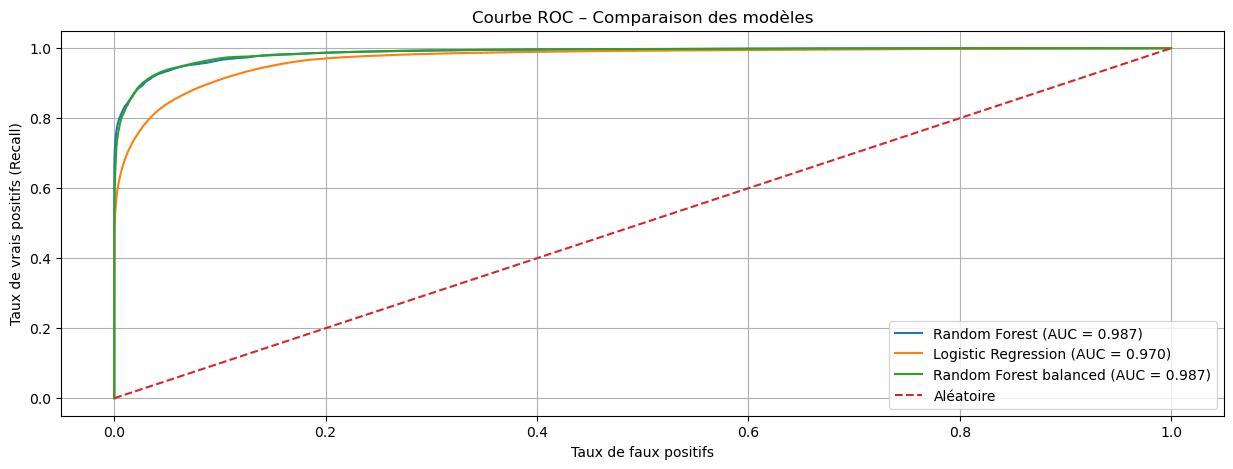

In [39]:
# groupe ROC 
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_test,proba_fraude)
fpr1, tpr1, _ = roc_curve(y_test,proba_fraude_logis)
fpr2, tpr2, _ = roc_curve(y_test,proba_fraude_rfb)

# AUC
auc_rf = roc_auc_score(y_test, proba_fraude)
auc_log = roc_auc_score(y_test, proba_fraude_logis)
auc_rfb = roc_auc_score(y_test, proba_fraude_rfb)

# Plot
plt.figure(figsize=(15,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr1, tpr1, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr2, tpr2, label=f"Random Forest balanced (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Aléatoire")

plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs (Recall)")
plt.title("Courbe ROC – Comparaison des modèles")
plt.legend()
plt.grid()
plt.show()

###  AUC = 0,987  -> excellent 

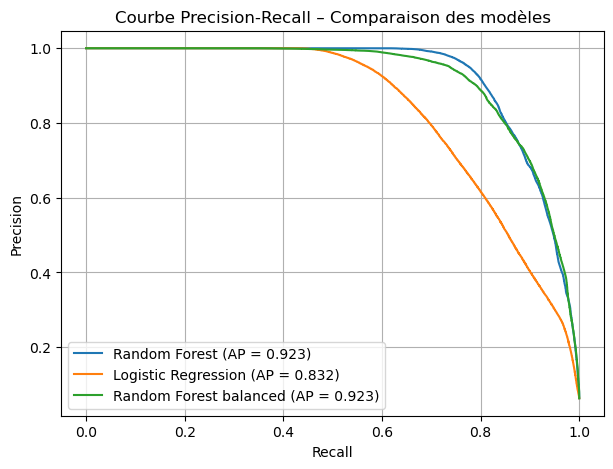

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# PR curves
precision_rf, recall_rf, _ = precision_recall_curve(y_test, proba_fraude)
precision_log, recall_log, _ = precision_recall_curve(y_test, proba_fraude_logis)
precision_rfb, recall_rfb, _ = precision_recall_curve(y_test,proba_fraude_rfb)

# Average Precision
ap_rf = average_precision_score(y_test, proba_fraude)
ap_log = average_precision_score(y_test, proba_fraude_logis)
ap_rfb = average_precision_score(y_test, proba_fraude_rfb)

# Plot
plt.figure(figsize=(7,5))
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {ap_rf:.3f})")
plt.plot(recall_log, precision_log, label=f"Logistic Regression (AP = {ap_log:.3f})")
plt.plot(recall_rfb, precision_rfb, label=f"Random Forest balanced (AP = {ap_rf:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall – Comparaison des modèles")
plt.legend()
plt.grid()
plt.show()



### Fonction de prédiction personnalisée 

In [35]:
# la fonction de prédiction 
def predict_churn(card_present,distance_from_home,weekend_transaction,date,heure,amount_eur,period_of_day_evening,period_of_day_morning,period_of_day_night,country_Brazil,country_Canada,country_France, country_Germany,country_Japan,country_Mexico,country_Nigeria,country_Russia,country_Singapore,    country_UK, country_USA,merchant_category_Entertainment,   merchant_category_Gas,merchant_category_Grocery,merchant_category_Healthcare,merchant_category_Restaurant,merchant_category_Retail,merchant_category_Travel        
):

       # Utiliser le modèle entraîné pour prédire la probabilité d'achat
    proba_fraude = model.predict_proba(X)[0][1]  # Prend la probabilité de la classe 1 (achat)
    
    return f"Probabilité d'achat : {proba_achat * 100:.2f}%"